In [1]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
from astropy.table import Table, Column
from astropy.io import ascii
from astropy.coordinates import SkyCoord,Angle
from astropy.time import Time
from astroplan import Observer
from Atmospheric_diffraction import *
%matplotlib inline 
import math
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl
plt.style.use('bmh')


In [59]:
#Class for AD Analysis
#Adapted from Myriam Rodrigues code
class AD_analysis:
    def __init__(self):
        #Loads config file for telescope numbers
        Path_Inst_config = './Architecture_parameters/'
        Config_tel = ConfigObj(Path_Inst_config+'Telescope_conf.ini')

        self.conditions = {} #Dictionary of environment conditions at Paranal
        self.conditions['temperature']= float(Config_tel['EnvConditions']['AirTemperature']) * u.deg_C
        self.conditions['humidity']= float(Config_tel['EnvConditions']['AirHumidity']) * u.percent
        self.conditions['pressure']= float(Config_tel['EnvConditions']['AirPressure']) * u.mBa
        self.plate_scale = float(Config_tel['OpticalInterfaces']['Plate_Scale']) #* u.arcsec / u.mm, MOSAIC plate scale
        
        self.VIS_fibre_diameter=0.69 * u.arcsec #Diameter of VIS MOS fibre
        self.IR_fibre_diameter=0.6 * u.arcsec #Diameter of IR MOS fibre
        self.median_FWHM=0.68 * u.arcsec #median seeing at Paranal zenith, wavelength = 500nm


    def airmass_from_Target_Loc(self,Latitude,Declination,HA_array):
        """
        Computes airmass for target/declination at a given latitude for a range of given hour angles

        INPUTS:
        latitude: float
            latitude of observer, in astropy units
        declination: float
            declination of target, in astropy units
        HA_array: array
            array of hour angles to compute airmasses for, in hours

        OUTPUTS:
        airmass_array: array
            array of airmasses for target at given hour angles
        """

        airmass_array = np.array([])
        for HA in HA_array:
            HA_deg=Angle(HA*u.hour)
            airmass=1/(np.sin(Latitude.rad)*np.sin(Declination.rad)+np.cos(Latitude.rad)*np.cos(Declination.rad)*np.cos(HA_deg.rad))
            airmass_array=np.append(airmass_array,airmass)
        return airmass_array

    def load_wave(self,res,regime,min_band,max_band,sampling=50):
        """
        Generates the monochromatic wavelengths to be used in the analysis

        INPUTS:
        res: string, LR or HR
            which MOSAIC resolution the analysis will use
        regime: string, VIS or NIR
            which MOSAIC wavelength regime the analysis will use
        min_band: string, if VIS+HR: V or R. If VIS+LR: B,V, or R. If NIR+HR: IY or H. If NIR+LR: IY,J, or H
            band to use for the minimum wavelength
        max_band: string, same as above
            band to use for the maximum wavelength
        sampling: float, in nm
            gap between each monochromatic wavelength

        OUTPUTS:
        Returns:
        None

        Class Variables:
        self.wave: array, in astropy units
            array of the different wavelengths
        """
        self.regime=regime
        self.min_band=min_band
        self.max_band=max_band
        self.res=res

        Path_Inst_config = './Architecture_parameters/'
        Config_regime = ConfigObj(Path_Inst_config+regime+'_channel_conf.ini')
        self.wave = np.arange(int(Config_regime[res]['Bands'][min_band]['wave_min']),int(Config_regime[res]['Bands'][max_band]['wave_max']),sampling) * u.nm
        self.sampling=sampling

        if regime == 'VIS':
            self.fibre_diameter=self.VIS_fibre_diameter
        elif regime == 'NIR':
            self.fibre_diameter=self.IR_fibre_diameter
            
        return
    
    def load_airmasses(self,HA_range=[],zenithangles_range=[],targ_dec='-25d33m00.0s'):
        self.HA_range=HA_range
        self.zenith_angle=zenithangles_range
        if HA_range != []:
            print("HA used")
            Paranal = Observer.at_site('Cerro Paranal') 
            Target = SkyCoord('0', targ_dec, frame='icrs', unit='deg')
            lat = Paranal.location.lat.rad
            dec = Target.dec.rad
            self.dec=dec
            LHA_below_horizon=np.rad2deg(np.arccos(-np.tan(lat)*np.tan(dec)))/15
            if str(LHA_below_horizon) != 'nan':
                print("Target goes below Horizon above/below HA of +/- %2.1fh" % (LHA_below_horizon))
                for val in HA_range.copy():
                    if val > LHA_below_horizon:
                        print("At HA %2.2fh, target goes below horizon - removing this from HA range" % (val))
                        HA_range.remove(val)
            if dec > np.pi/2 + lat and lat < 0:
                print("Target always below Horizon")
                HA_range=[]
            target = SkyCoord('00h00m00.0s',targ_dec,frame='icrs')
            self.HA_range=HA_range
            self.airmasses=self.airmass_from_Target_Loc(Paranal.location.lat,target.dec,HA_range)
        
        elif zenithangles_range != []:
            print("Zenith Angles Used")
            self.airmasses=[]
            
            for i in zenithangles_range:
                self.airmasses.append(1/np.cos(np.deg2rad(i)))
            self.airmasses=np.array(self.airmasses)


    #AD shifts from guide wavelength centre for each wavelength after each integration
    def shifts(self, wave_ref=0.537 * u.micron,plot=False, fibre_centre=0.537 * u.micron, reposition = False):
        self.wave_ref=wave_ref
        if reposition == True:
            print("Reposition = True")
            self.fibre_centre=fibre_centre
            self.shifts=[]
            for i in self.airmasses:
                self.centre_shift=Atmospheric_diffraction(self.fibre_centre,i,self.wave_ref,self.conditions) #fibre is repositioned each time to new centre for new airmass
                shift=Atmospheric_diffraction(self.wave,i,self.wave_ref,self.conditions)-self.centre_shift
                self.shifts.append(shift)

        elif reposition == False:
            print("Reposition = False")
            self.fibre_centre=fibre_centre
            self.centre_shift=Atmospheric_diffraction(self.fibre_centre,self.airmasses[0],wave_ref,self.conditions)
            self.shifts=[]
            for i in self.airmasses:
                shift=Atmospheric_diffraction(self.wave,i,wave_ref,self.conditions)-self.centre_shift #shift is always relative to original centre
                self.shifts.append(shift)
        
        if plot==True:
            T_arc = lambda T_mm: T_mm * self.plate_scale
            T_mm = lambda T_arc: T_arc / self.plate_scale
            fig, ax = plt.subplots(figsize=(10,7))
            ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
            plt.axhline(0,linewidth=0.5,color='black',label='Fibre Centre')
            plt.axhline(-self.centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
            for i in range(0,len(self.airmasses)):
                plt.plot(self.wave,self.shifts[i],label="HA = %2.2fh" %(self.HA_range[i]))
            plt.title('Wavelength Reference %s, Fibre Centre on %s, Dec = %2.2f deg' %(self.wave_ref,self.fibre_centre,np.rad2deg(self.dec)))
            plt.legend(loc='best')
            ax.set_ylabel('Displacement from Fibre Centre [arcsec]')
            ax2.set_ylabel('Displacement from Fibre Centre [mm]')
            ax.set_xlabel('Wavelength [nm]')

            fig, ax = plt.subplots(figsize=(10,7))
            plt.axvline(0,linewidth=0.5,color='black',label='Fibre Centre')
            plt.axvline(-self.centre_shift.value,linewidth=0.5,color='red',label='Wavelength Reference Centre')
            xvals=np.linspace(-1,1,len(self.wave))
            c=np.tan(xvals)
            for i in range(0,len(self.shifts)):
                yvals=np.full(len(self.shifts[i]),self.HA_range[i])
                plt.scatter(self.shifts[i],yvals,c=c)
                norm = plt.Normalize(self.wave.value.min(), self.wave.value.max())
                points = np.array([self.shifts[i], yvals]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, cmap='viridis', norm=norm)
                lc.set_array(self.wave.value)
                lc.set_linewidth(2)
                line=ax.add_collection(lc)
            fig.colorbar(line)
            plt.xlabel('Displacement from Fibre Centre [arcsec]')
            plt.ylabel('Hour Angle [h]')
            plt.yticks(np.linspace(min(self.HA_range),max(self.HA_range),len(self.HA_range)))
            plt.legend()
            plt.title('Wavelength Reference %s, Fibre Centre on %s, Dec = %2.2f deg' %(self.wave_ref,self.fibre_centre,np.rad2deg(self.dec)))

    #how far each wavelength has shifted from it's previous position after each integration
    def integration_shifts(self,plot=True):
        T_arc = lambda T_mm: T_mm * self.plate_scale
        T_mm = lambda T_arc: T_arc / self.plate_scale

        self.int_shifts=[]
        for i in range(1,len(self.shifts)):
            a=[]
            for o in range(0,len(self.shifts[0])):
                a.append((self.shifts[i][o]-self.shifts[i-1][o]).value)
            self.int_shifts.append(a)

        if plot==True:
            fig, ax = plt.subplots(figsize=(10,7))
            ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
            plt.style.use('bmh')
            for i in range(0,len(self.int_shifts)):
                plt.plot(self.wave,self.int_shifts[i],label="HA = %2.2f to %2.2fh" %(self.HA_range[i],self.HA_range[i+1]))
            plt.title('Wavelength Reference %s, dec = %2.2f deg' %(self.wave_ref,np.rad2deg(self.dec)))
            plt.legend(loc='best')
            ax.set_ylabel('AD Shift Change per Integration [arcsec]')
            ax2.set_ylabel('Displacement from Fibre Centre [mm]')
            ax.set_xlabel('Wavelength [nm]')

            fig, ax = plt.subplots(figsize=(10,7))
            plt.axvline(0,linewidth=0.5,color='black',label='Wavelength Reference Centre')
            xvals=np.linspace(-1,1,len(self.wave))
            c=np.tan(xvals)
            for i in range(0,len(self.int_shifts)):
                yvals=np.full(len(self.int_shifts[i]),self.HA_range[i])
                plt.scatter(self.int_shifts[i],yvals,c=c)
                norm = plt.Normalize(self.wave.value.min(), self.wave.value.max())
                points = np.array([self.int_shifts[i], yvals]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, cmap='viridis', norm=norm)
                lc.set_array(self.wave.value)
                lc.set_linewidth(2)
                line=ax.add_collection(lc)
            fig.colorbar(line)
            plt.xlabel('AD Shift Change each Integration [arcsec]')
            plt.ylabel('Hour Angle Integration')
            plt.title('Wavelength Reference %s, dec = %2.2f deg' %(self.wave_ref,np.rad2deg(self.dec)))  
            plt.yticks(np.linspace(min(self.HA_range),max(self.HA_range),len(self.HA_range)))
            labels = [item.get_text() for item in ax.get_yticklabels()]
            for i in range(0,len(self.HA_range)-1):
                labels[i]="%2.2f to %2.2fh" %(self.HA_range[i],self.HA_range[i+1])
            ax.set_yticklabels(labels)
                
                    
    def FWHM_recalc(self,wavelength,airmass):
        FWHM_median=self.median_FWHM #arcsec
        ref_wavelength=500 #nm
        FWHM=FWHM_median.value*(ref_wavelength/wavelength)**(1/5)*(1/airmass)**(-3/5)
        return FWHM
    
    #https://opg.optica.org/ao/fulltext.cfm?uri=ao-58-4-1048&id=404390
    def transmission(self,fibre_diameter,FWHM,offset,k_lim=50):
        fibre_radius=fibre_diameter/2
        prefactor=np.exp(-4*np.log(2)*offset**2/FWHM**2)
        k_sum=0
        for k in range(0,k_lim):
            i_sum=0
            for i in range(0,k+1):
                i_sum=i_sum+(2**i*fibre_radius**(2*i)/math.factorial(i))*(2*np.log(2)/FWHM**2)**i
            k_sum=k_sum+2**k*offset**(2*k)/math.factorial(k)*(2*np.log(2)/FWHM**2)**k*(1-np.exp(-4*np.log(2)*fibre_radius**2/FWHM**2)*i_sum)
        T=prefactor*k_sum
        return T



    def transmission_change(self,k_lim=50,FWHM_change=True, normalise=False):     
        """
        DESD

        INPUTS:
        k_lim: float, default=50
            number of terms to compute the sum to for the analytic transmission solution
        FWHM_change: string, True or False
            fill
        normalise: 
            fill


        OUTPUTS:

        """
        weights = np.arange(1, len(self.airmasses))
        norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)


        if FWHM_change == True: #Is there a dependence of the FWHM on airmass and wavelength?
            FWHM_list = [] #List of the FWHM across the wave for each airmass, [[airmass 1 wave FWHM],[airmass 2 wave FWHM],....]
            for i in self.airmasses: #For each airmass, calculate the FWHM for each wavelength in the wave
                FWHM_list.append(self.FWHM_recalc(self.wave.value,i))
            self.wave_transmissions=self.transmission(self.fibre_diameter.value,np.array(FWHM_list),np.array(self.shifts),k_lim=k_lim) #Transmission of light into fibre using changing FWHM

        optimal_transmissions = []
        optimal_FWHM_list=[]


        fig, ax = plt.subplots(figsize=(10,7))
        plt.axvline(self.fibre_centre.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
        i=0
        for i in range(0,len(self.wave_transmissions)):
            plt.plot(self.wave,np.array(self.wave_transmissions[i])/np.array(self.wave_transmissions[0])/(self.wave_transmissions[i][230]/self.wave_transmissions[0][230]),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i))

        plt.ylabel("Transmission")
        plt.xlabel("Wavelength [nm]")
        plt.title('Fibre Centre on %s, NIR All, FWHM Change = %s' %(self.fibre_centre,FWHM_change))
        plt.ylim(0,1.05)
        plt.legend()
        #plt.savefig('NIR_normx3.png', dpi=300)
        print(self.wave[430])




        # optimalFWHM_list=[] 
        # if FWHM_change==True:
        #     FWHM_list = []
        #     for i in self.airmasses:
        #         FWHM_list.append(self.FWHM_recalc(self.wave.value,i))
        #     self.transmissions=self.transmission(self.fibre_diameter.value,np.array(FWHM_list),np.array(self.shifts),k_lim=k_lim)
        #     optimalFWHM_list.append(self.FWHM_recalc(self.wave.value,1))
        #     optimalvals=self.transmission(self.fibre_diameter.value,np.array(optimalFWHM_list),0)
        # else:
        #     self.transmissions=self.transmission(self.fibre_diameter.value,self.median_FWHM.value,np.array(self.shifts),k_lim=k_lim)
        #     for i in range(0,len(self.airmasses)):
        #         optimalFWHM_list.append(self.median_FWHM.value)
        #     optimalvals=self.transmission(self.fibre_diameter.value,np.array(optimalFWHM_list),0)

        
        # if self.zenith_angle != []:


        #     fig, ax = plt.subplots(figsize=(10,7))
        #     plt.axvline(self.fibre_centre.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
        #     i=0
        #     plt.plot(self.wave,np.array(self.transmissions[i])/np.array(optimalvals[0]),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i))
        #     for i in range(1,int((len(self.transmissions)+1)/2)):
        #         plt.plot(self.wave,np.array(self.transmissions[2*i])/np.array(optimalvals[0]),label='%2.0f' %(self.zenith_angle[2*i]),color=cmap.to_rgba(2*i+1))
        #         plt.plot(self.wave,np.array(self.transmissions[2*i-1])/np.array(optimalvals[0]),color=cmap.to_rgba(2*i))
        #     plt.ylabel("Transmission")
        #     plt.xlabel("Wavelength [nm]")
        #     plt.title('Fibre Centre on %s, %s %s %s, FWHM Change = %s' %(self.fibre_centre,self.regime,self.res,self.min_band,FWHM_change))

        #     plt.ylim(0,1.05)

            
        #     plt.legend()

            



Zenith Angles Used
Reposition = True
1200.0 nm


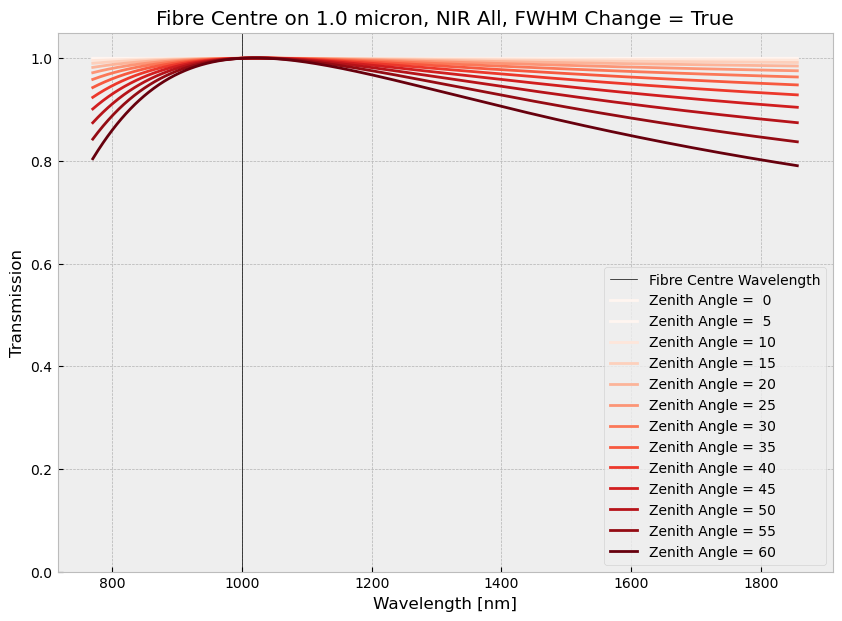

In [60]:


analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1)
analysis.load_airmasses(zenithangles_range=[0,5,10,15,20,25,30,35,40,45,50,55,60])
analysis.shifts(fibre_centre = 1 * u.micron,plot=False, reposition=True)
analysis.integration_shifts(plot=False)
analysis.transmission_change(k_lim=30, FWHM_change=True)

HA used
Target goes below Horizon above/below HA of +/- 6.8h
Reposition = False


IndexError: list index out of range

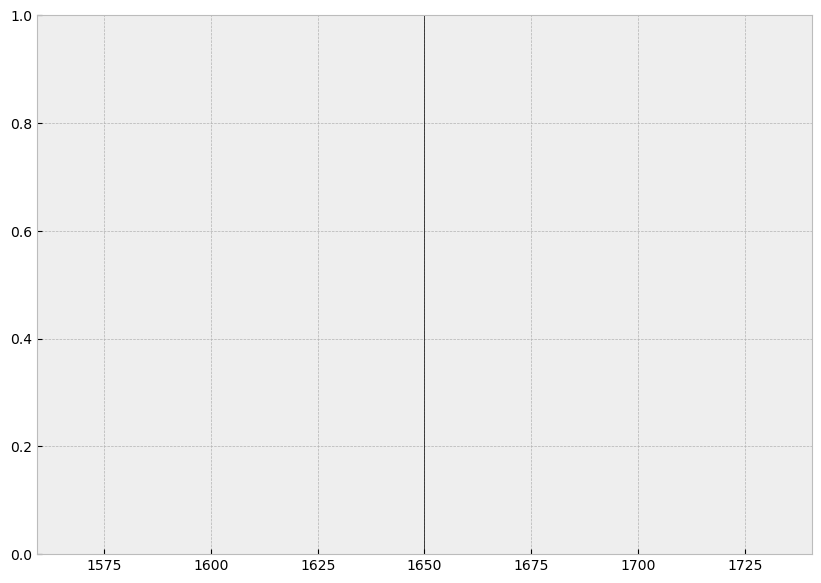

In [12]:



analysis=AD_analysis()
analysis.load_wave('LR','NIR','H','H',sampling=1)
analysis.load_airmasses(HA_range=[0,0.25,0.5,0.75,1])
analysis.shifts(fibre_centre = 1.65 * u.micron,plot=False)
analysis.integration_shifts(plot=False)
analysis.transmission_change(k_lim=30, FWHM_change=True)

0.10984562619285904


0.10987218019218827

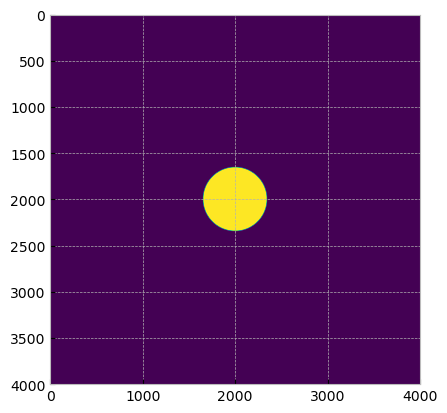

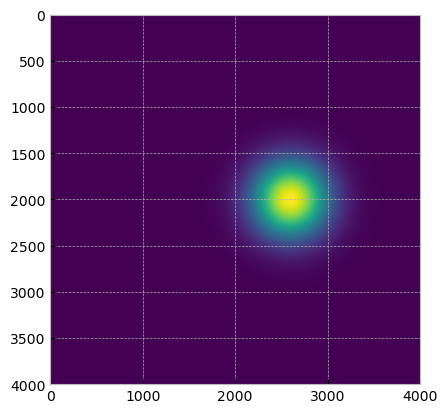

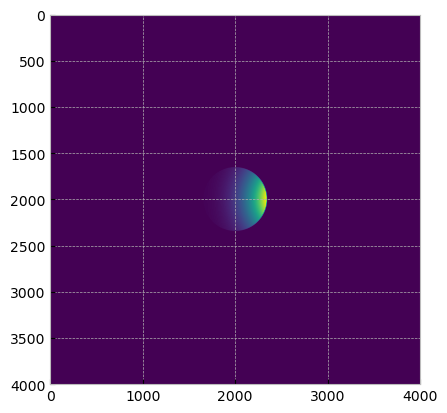

In [39]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling.functional_models import Disk2D
from astropy.modeling.models import Gaussian2D

scale=0.001 #1 pixel = scale arcsecs
FWHM=0.68
fibre_diameter=0.69

x = np.arange(-2000, 2001)
y = np.arange(-2000, 2001)
x, y = np.meshgrid(x, y)

std = FWHM/(2*np.sqrt(2*np.log(2)))/scale
x_pos=0.6/scale

Disk=Disk2D(1,0,0,fibre_diameter/2/scale)
Disk_data=Disk(x,y)
Gaussian=Gaussian2D(1,x_pos,0,std,std)
Gaussian_data=Gaussian(x,y)
convolved_data=np.zeros(Gaussian_data.shape)

gaussian_sum=0
convolved_sum=0
for i in range(0,len(Gaussian_data)):
    for a in range(0,len(Gaussian_data[i])):
        val = Gaussian_data[i][a]*Disk_data[i][a]
        convolved_data[i][a]= val
        convolved_sum = convolved_sum+val
        gaussian_sum = gaussian_sum + Gaussian_data[i][a]

fig, ax = plt.subplots()
ax.imshow(Disk_data)
fig, ax = plt.subplots()
ax.imshow(Gaussian_data)
fig, ax = plt.subplots()
ax.imshow(convolved_data)

print(convolved_sum/gaussian_sum)
analysis.transmission(fibre_diameter,FWHM,x_pos*scale,k_lim=60)




In [12]:
a=np.array([3,4,5])
b=np.array([4,6,1])
print(a/b)


[0.75       0.66666667 5.        ]


In [ ]:
            weights = np.arange(1, len(self.airmasses))
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
            fig, ax = plt.subplots(figsize=(10,7))
            plt.axvline(self.fibre_centre.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
            i=0
            plt.plot(self.wave,np.array(self.transmissions[i])/np.array(optimalvals[0]),label='Zenith Angle = %2.0f' %(self.zenith_angle[i]),color=cmap.to_rgba(i))
            for i in range(1,int((len(self.transmissions)+1)/2)):
                plt.plot(self.wave,np.array(self.transmissions[2*i])/np.array(optimalvals[0]),label='%2.0f' %(self.zenith_angle[2*i]),color=cmap.to_rgba(2*i+1))
                plt.plot(self.wave,np.array(self.transmissions[2*i-1])/np.array(optimalvals[0]),color=cmap.to_rgba(2*i))
            plt.ylabel("Transmission")
            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre Centre on %s, %s %s %s, FWHM Change = %s' %(self.fibre_centre,self.regime,self.res,self.min_band,FWHM_change))

            plt.ylim(0,1.05)

            
            plt.legend()

In [32]:
np.deg2rad(5)

0.08726646259971647

<function Disk2D.evaluate at 0x7f824addf680>


In [53]:
b=[3,4,5]
b=np.array(b)

In [54]:
print(b+2)

[5 6 7]


0.06719748563355496

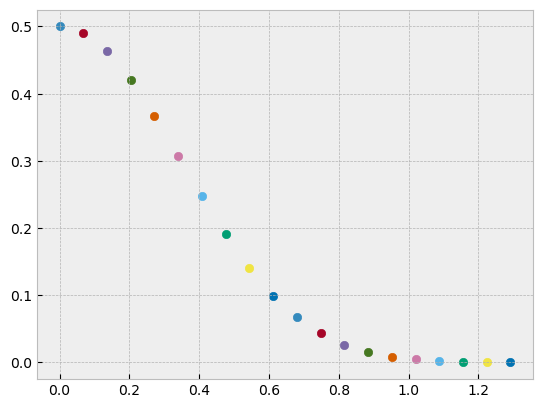

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])